In [1]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
plt.rcParams["figure.figsize"] = (6, 4)

<IPython.core.display.Javascript object>

In [4]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_pacs_resampled.hdf"
)

<IPython.core.display.Javascript object>

In [5]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def make_lowess(series, frac=0.666):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x, frac=frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

<IPython.core.display.Javascript object>

In [6]:
def chunk_series(df, xvarname, yvarname, n=50):
    """Break a population into chunks and compute a mean for each chunk.

    Sort by `xvarname`, break into chunks, and compute the mean of column `yvarname`

    df: DataFrame
    xvarname: variable
    yvarname: variable
    size: chunk size

    returns: pd.Series
    """
    subset = df[[xvarname, yvarname]].dropna().sort_values(by=xvarname).reset_index()
    size = int(len(df) // n) + 1
    subset["chunk"] = subset.index // size
    groupby = subset.groupby("chunk")
    x = groupby[xvarname].mean()
    y = groupby[yvarname].mean()

    return pd.Series(y.values, x)

<IPython.core.display.Javascript object>

In [7]:
def plot_series_lowess(series, color, plot_series=False, frac=0.7, **options):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    if "label" not in options:
        options["label"] = series.name

    if plot_series or len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.3, label="_")

    if not plot_series and len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.6, label=options["label"])

    if len(series) > 1:
        smooth = make_lowess(series, frac=frac)
        smooth.plot(color=color, **options)

<IPython.core.display.Javascript object>

In [8]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

<IPython.core.display.Javascript object>

In [9]:
def decorate_anchor(**options):
    decorate(**options)
    anchor_legend(1.02, 1.02)

<IPython.core.display.Javascript object>

## Load the data

In [10]:
datafile = "gss_pacs_resampled.hdf"
gss = pd.read_hdf(datafile, "gss0")
gss.shape

(68846, 204)

<IPython.core.display.Javascript object>

In [11]:
gss["polviews"].value_counts()

4.0    22950
5.0     9344
6.0     9064
3.0     7408
2.0     6876
7.0     1951
1.0     1911
Name: polviews, dtype: int64

<IPython.core.display.Javascript object>

In [12]:
columns = [
    "Extremely liberal",
    "Liberal",
    "Slightly liberal",
    "Moderate",
    "Slightly conservative",
    "Conservative",
    "Extremely conservative",
]

<IPython.core.display.Javascript object>

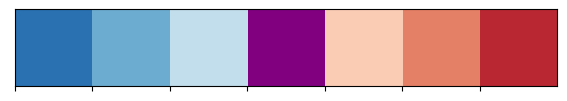

<IPython.core.display.Javascript object>

In [13]:
palette = sns.color_palette("RdBu_r", 7)
palette[3] = "purple"
sns.palplot(palette)

In [14]:
color_map = dict(zip(columns, palette))

<IPython.core.display.Javascript object>

In [15]:
# recode the 7 point scale with words
d7 = dict(zip(range(1, 8), columns))
polviews7 = gss["polviews"].replace(d7)

<IPython.core.display.Javascript object>

In [16]:
xtab = pd.crosstab(gss["year"], polviews7, normalize="index") * 100

<IPython.core.display.Javascript object>

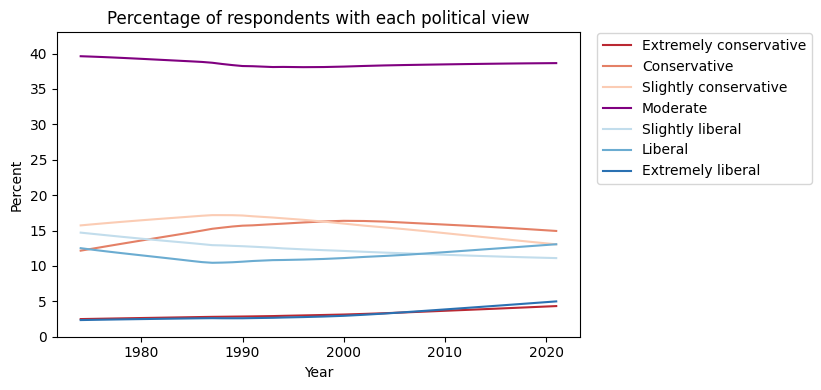

<IPython.core.display.Javascript object>

In [17]:
for column in reversed(columns):
    plot_series_lowess(xtab[column], color_map[column])

decorate(
    xlabel="Year",
    ylabel="Percent",
    ylim=[0, 43],
    title="Percentage of respondents with each political view",
)

plt.legend(bbox_to_anchor=(1.02, 1.02))
plt.savefig("alignment1.jpg", dpi=600)

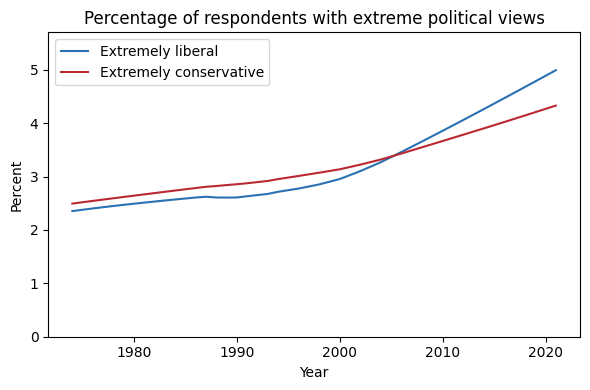

<IPython.core.display.Javascript object>

In [18]:
selected_columns = ["Extremely liberal", "Extremely conservative"]

for column in selected_columns:
    plot_series_lowess(xtab[column], color_map[column])

decorate(
    xlabel="Year",
    ylabel="Percent",
    ylim=[0, 5.7],
    title="Percentage of respondents with extreme political views",
)
plt.savefig("alignment2.jpg", dpi=600)

## But what do people think?

In [19]:
convervative_values = {
    "abany": [2],
    "homosex": [1, 2, 3],
    "premarsx": [1, 2, 3],
    "prayer": [2],
    "natfare": [3],
    "grass": [2],
    "natenvir": [2, 3],  # about right or too much
    "divlaw": [2],
    "cappun": [1],
    "racopen": [1],
    "letdie1": [2],
    "fepol": [1],
    "gunlaw": [2],
    "sexeduc": [2],
    "pornlaw": [1],
}

len(convervative_values)

15

<IPython.core.display.Javascript object>

In [20]:
order = [
    "homosex",
    "cappun",
    "grass",
    "abany",
    "prayer",
    "premarsx",
    "divlaw",
    "natfare",
    "natenvir",
    "pornlaw",
    "racopen",
    "letdie1",
    "fepol",
    "gunlaw",
    "sexeduc",
]

<IPython.core.display.Javascript object>

In [21]:
questions = pd.DataFrame(dtype=int)

for varname in order:
    questions[varname] = gss[varname].isin(convervative_values[varname])
    null = gss[varname].isna()
    questions.loc[null, varname] = np.nan

questions.mean().sort_values()

sexeduc     0.123325
gunlaw      0.248929
fepol       0.288109
letdie1     0.316651
pornlaw     0.367058
racopen     0.380694
natenvir    0.382327
natfare     0.472358
divlaw      0.491076
premarsx    0.544122
abany       0.588317
prayer      0.594057
grass       0.690478
cappun      0.704263
homosex     0.712433
dtype: float64

<IPython.core.display.Javascript object>

In [22]:
recode_polviews = {
    1: "Liberal",
    2: "Liberal",
    3: "Liberal",
    4: "Moderate",
    5: "Conservative",
    6: "Conservative",
    7: "Conservative",
}

<IPython.core.display.Javascript object>

In [23]:
gss["polviews3"] = gss["polviews"].replace(recode_polviews)

<IPython.core.display.Javascript object>

In [24]:
augmented = pd.concat([questions, gss["polviews3"]], axis=1)
table = augmented.groupby("polviews3").mean().transpose() * 100
table

polviews3,Conservative,Liberal,Moderate
homosex,81.371473,54.320631,71.618967
cappun,79.193957,57.111334,72.561063
grass,76.681390,55.228505,68.815558
abany,69.454161,42.408271,59.034743
prayer,66.921328,44.034656,62.489640
premarsx,64.948614,39.548625,52.102950
divlaw,58.584027,38.215031,48.069738
natfare,58.132612,34.057891,47.810538
natenvir,48.582110,26.005274,37.252730
pornlaw,44.144622,25.063638,35.870748


<IPython.core.display.Javascript object>

In [25]:
(table["Conservative"] - table["Liberal"]).sort_values()

sexeduc     11.183597
fepol       11.955424
gunlaw      12.877920
letdie1     14.487343
racopen     14.548237
pornlaw     19.080984
divlaw      20.368996
grass       21.452885
cappun      22.082623
natenvir    22.576836
prayer      22.886672
natfare     24.074721
premarsx    25.399990
abany       27.045890
homosex     27.050842
dtype: float64

<IPython.core.display.Javascript object>

In [26]:
issue_dict = {
    "abany": "Abortion",
    "homosex": "Homosexuality",
    "premarsx": "Premarital sex",
    "prayer": "School prayer",
    "natfare": "Welfare spending",
    "grass": "Legal cannabis",
    "natenvir": "Environment",
    "divlaw": "Divorce",
    "cappun": "Capital punishment",
    "racopen": "Fair housing law",
    "letdie1": "Assisted suicide",
    "fepol": "Women in politics",
    "gunlaw": "Gun law",
    "sexeduc": "Sex education",
    "pornlaw": "Pornography",
}

issue_names = pd.Series(issue_dict)[order].values

<IPython.core.display.Javascript object>

For each question, I identified the responses more likely to be chosen by conservatives.
The following figure shows, for each question, the percentage of liberals, moderates, and conservatives who chose one of the conservative responses.

In [27]:
polview_names = ["Conservative", "Moderate", "Liberal"]
party_names = ["Republican", "Independent", "Democrat"]

marker_map = dict(zip(polview_names, ["s", "^", "o"]))
line_map = dict(zip(polview_names, ["--", "-.", ":"]))

<IPython.core.display.Javascript object>

In [28]:
muted = sns.color_palette("muted", 5)
polview_map = dict(zip(polview_names, [muted[3], muted[4], muted[0]]))
party_map = dict(zip(party_names, [muted[3], muted[4], muted[0]]))



<IPython.core.display.Javascript object>

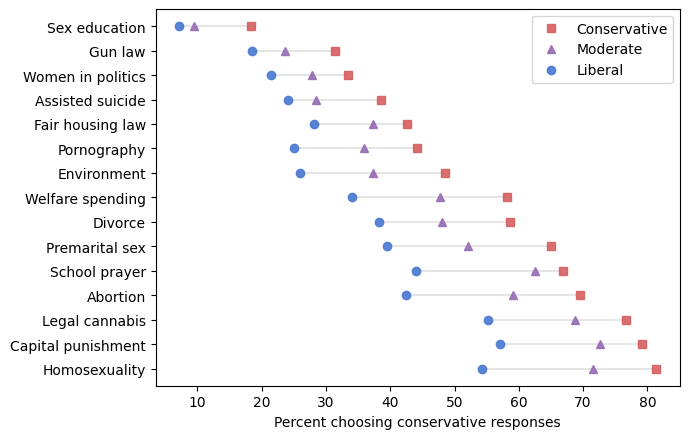

<IPython.core.display.Javascript object>

In [29]:
plt.figure(figsize=(7, 4.5))
plt.hlines(
    issue_names,
    table["Liberal"],
    table["Conservative"],
    color="gray",
    alpha=0.2,
)

for polviews, color in polview_map.items():
    x = table[polviews]
    marker = marker_map[polviews]
    plt.plot(x, issue_names, marker, color=color, alpha=0.9, label=polviews)

decorate(xlabel="Percent choosing conservative responses")
plt.savefig("alignment3.jpg", dpi=600)

In [30]:
# some questions are "easier" than others; we can use the logit of the prevalence
# for each question to estimate its difficulty

from scipy.special import logit

difficulty = -logit(questions.mean())
difficulty

homosex    -0.907229
cappun     -0.867682
grass      -0.802355
abany      -0.357012
prayer     -0.380762
premarsx   -0.176949
divlaw      0.035700
natfare     0.110683
natenvir    0.479683
pornlaw     0.544857
racopen     0.486605
letdie1     0.769207
fepol       0.904585
gunlaw      1.104332
sexeduc     1.961313
dtype: float64

<IPython.core.display.Javascript object>

In [31]:
# if we make a mesh with one row for each efficacy and one column for each question,
# we can make a mapping from each efficacy to the number of conservative answers we
# expect from a person with each efficacy

from scipy.special import expit

xs = np.linspace(-6, 6, 21)
X, D = np.meshgrid(xs, difficulty)
P = expit(X - D)
Q = 1 - P
ns = P.sum(axis=0)

<IPython.core.display.Javascript object>

In [32]:
# as a prior for efficacy, I'll use a wide Gaussian, which represents
# a gentle bias toward the middle of the range

from scipy.stats import norm
from empiricaldist import Pmf

ys = norm.pdf(xs, 0, 4)
prior = Pmf(ys, xs)
prior.normalize()

1.4751408263256967

<IPython.core.display.Javascript object>

In [33]:
# compute the results for all respondents with a single 3-D array:
# one row for each respondent,
# one column for each question,
# one page for each hypothetical value of efficacy

n, m = questions.shape
size = n, m, len(xs)
res = np.empty(size)
res.shape

(68846, 15, 21)

<IPython.core.display.Javascript object>

In [34]:
# now we can fill the array with the likelihoods of conservative and non-conservative
# responses; where there's a NaN, we fill in all 1

a = questions.fillna(2).astype(int).values
ii, jj = np.nonzero(a == 0)
res[ii, jj, :] = Q[jj]
ii, jj = np.nonzero(a == 1)
res[ii, jj, :] = P[jj]
ii, jj = np.nonzero(a == 2)
res[ii, jj, :] = 1

<IPython.core.display.Javascript object>

In [35]:
# multiplying along the rows gives the likelihood of each row of responses,
# which we multiply by the prior probabilities

product = res.prod(axis=1) * prior.values
product.shape

(68846, 21)

<IPython.core.display.Javascript object>

In [36]:
# normalize the rows to get a posterior distribution for each respondent

posterior = product / product.sum(axis=1)[:, None]
posterior.shape

(68846, 21)

<IPython.core.display.Javascript object>

In [37]:
# compute the means of the posterior distributions

con = (posterior * ns).sum(axis=1)
con.shape

(68846,)

<IPython.core.display.Javascript object>

In [38]:
# and the variances of the posterior distributions

deviations = ns - con[:, None]
var_con = (posterior * deviations**2).sum(axis=1)
std_con = np.sqrt(var_con)
std_con.shape

(68846,)

<IPython.core.display.Javascript object>

In [39]:
answered = questions.notna().sum(axis=1)
(answered >= 5).mean()

0.9065595677308776

<IPython.core.display.Javascript object>

In [40]:
gss["conservatism"] = pd.Series(con, gss.index) + np.random.normal(0, 0.2, len(con))
gss.loc[answered < 5, "conservatism"] = np.nan
gss["conservatism"].describe()

count    62413.000000
mean         6.913594
std          3.197122
min         -0.096221
25%          4.550199
50%          6.931292
75%          9.276482
max         14.931430
Name: conservatism, dtype: float64

<IPython.core.display.Javascript object>

## Change in location and spread

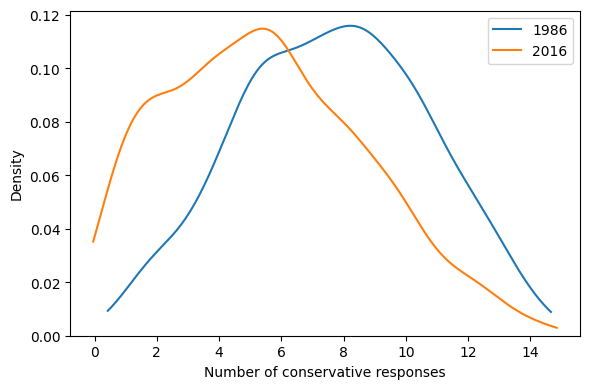

<IPython.core.display.Javascript object>

In [41]:
by_year = gss.groupby("year")

selected_years = [1986, 2016]
for year in selected_years:
    group = by_year.get_group(year)
    sns.kdeplot(group["conservatism"], cut=0, bw_adjust=1.3, label=year)

decorate(xlabel="Number of conservative responses")
plt.savefig("alignment4.jpg", dpi=600)

In [42]:
series_conservatism = gss.groupby("year")["conservatism"].mean()
series_conservatism.loc[selected_years]

year
1986    7.641411
2016    5.507386
Name: conservatism, dtype: float64

<IPython.core.display.Javascript object>

In [43]:
def highlight_years(series, years):
    plt.plot(series.loc[years], "x", color="C4")

<IPython.core.display.Javascript object>

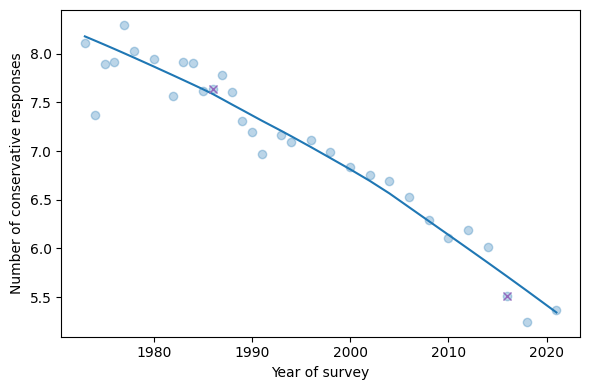

<IPython.core.display.Javascript object>

In [44]:
plot_series_lowess(series_conservatism, plot_series=True, color="C0", label="")
highlight_years(series_conservatism, selected_years)

decorate(xlabel="Year of survey", ylabel="Number of conservative responses")
plt.savefig("alignment5.jpg", dpi=600)

In [45]:
std_year = gss.groupby("year")["conservatism"].std()
std_year.loc[selected_years]

year
1986    3.008104
2016    3.198233
Name: conservatism, dtype: float64

<IPython.core.display.Javascript object>

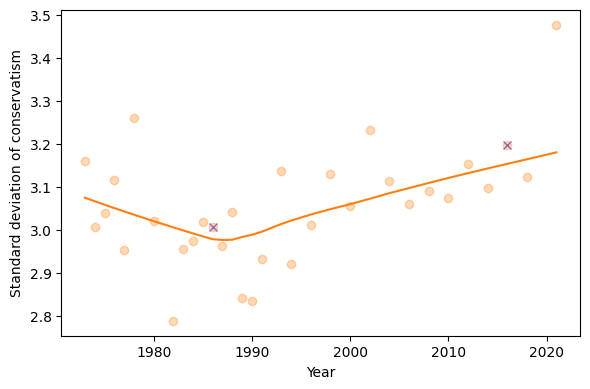

<IPython.core.display.Javascript object>

In [46]:
plot_series_lowess(std_year, "C1", plot_series=True, label="")
highlight_years(std_year, selected_years)
decorate(xlabel="Year", ylabel="Standard deviation of conservatism")
plt.savefig("alignment6.jpg", dpi=600)

In [47]:
def compute_mad(seq):
    con = seq.dropna()
    if len(con) == 0:
        return np.nan
    X, Y = np.meshgrid(con, con)
    return np.abs(X - Y).mean()

<IPython.core.display.Javascript object>

In [48]:
series_mad = pd.Series(dtype=float)
for name, group in gss.groupby("year"):
    con = group["conservatism"].dropna()
    series_mad.loc[name] = compute_mad(con)

<IPython.core.display.Javascript object>

In [49]:
series_mad = gss.groupby("year")["conservatism"].agg(compute_mad)
series_mad.loc[selected_years]

year
1986    3.437173
2016    3.641171
Name: conservatism, dtype: float64

<IPython.core.display.Javascript object>

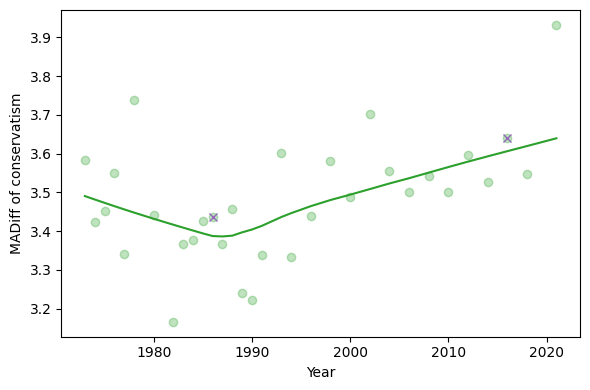

<IPython.core.display.Javascript object>

In [50]:
plot_series_lowess(series_mad, color="C2", plot_series=True, label="")
highlight_years(series_mad, selected_years)
decorate(xlabel="Year", ylabel="MADiff of conservatism")
plt.savefig("alignment7.jpg", dpi=600)

## Conservatism by polviews

In [51]:
table = gss.pivot_table(
    index="year", columns="polviews3", values="conservatism", aggfunc=compute_mad
)

<IPython.core.display.Javascript object>

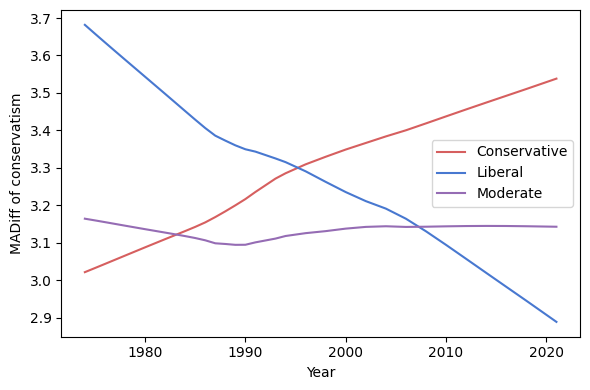

<IPython.core.display.Javascript object>

In [52]:
columns = ["Conservative", "Liberal", "Moderate"]
for column in columns:
    plot_series_lowess(table[column], polview_map[column])

decorate(
    xlabel="Year",
    ylabel="MADiff of conservatism",
)

## Polarization by party

In [54]:
recode_party = {
    0: "Strong democrat",
    1: "Not very strong democrat",
    2: "Independent, close to democrat",
    3: "Independent",
    4: "Independent, close to republican",
    5: "Not very strong republican",
    6: "Strong republican",
    7: np.nan,
}
gss["party7"] = gss["partyid"].replace(recode_party)
gss["party7"].value_counts()

Not very strong democrat            13887
Independent                         10768
Strong democrat                     10731
Not very strong republican          10513
Independent, close to democrat       8024
Strong republican                    6955
Independent, close to republican     6316
Name: party7, dtype: int64

<IPython.core.display.Javascript object>

In [55]:
columns = list(recode_party.values())[:-1]
columns

['Strong democrat',
 'Not very strong democrat',
 'Independent, close to democrat',
 'Independent',
 'Independent, close to republican',
 'Not very strong republican',
 'Strong republican']

<IPython.core.display.Javascript object>

In [56]:
color_map = dict(zip(columns, palette))
color_map

{'Strong democrat': (0.16339869281045757,
  0.44498269896193776,
  0.6975009611687812),
 'Not very strong democrat': (0.4206843521722416,
  0.6764321414840447,
  0.8186851211072664),
 'Independent, close to democrat': (0.7614763552479817,
  0.8685121107266438,
  0.924567474048443),
 'Independent': 'purple',
 'Independent, close to republican': (0.9824682814302191,
  0.8006920415224913,
  0.7061130334486736),
 'Not very strong republican': (0.8945790080738177,
  0.5038062283737024,
  0.39976931949250283),
 'Strong republican': (0.7284890426758939,
  0.15501730103806227,
  0.1973856209150327)}

<IPython.core.display.Javascript object>

In [57]:
xtab = pd.crosstab(gss["year"], gss["party7"], normalize="index") * 100

<IPython.core.display.Javascript object>

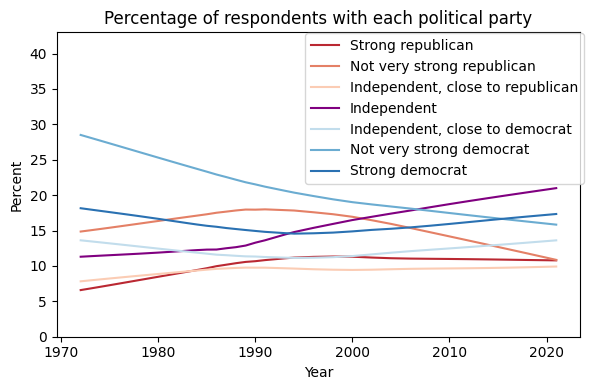

<IPython.core.display.Javascript object>

In [58]:
for column in reversed(columns):
    plot_series_lowess(xtab[column], color_map[column])

decorate(
    xlabel="Year",
    ylabel="Percent",
    ylim=[0, 43],
    title="Percentage of respondents with each political party",
)

plt.legend(bbox_to_anchor=(1.02, 1.02))

In [59]:
recode_party = {
    0: "Democrat",
    1: "Democrat",
    2: "Independent",
    3: "Independent",
    4: "Independent",
    5: "Republican",
    6: "Republican",
    7: np.nan,
}
gss["party3"] = gss["partyid"].replace(recode_party)
gss["party3"].value_counts()

Independent    25108
Democrat       24618
Republican     17468
Name: party3, dtype: int64

<IPython.core.display.Javascript object>

In [60]:
xtab = pd.crosstab(gss["year"], gss["party3"], normalize="index") * 100
xtab.head()

party3,Democrat,Independent,Republican
year,,,
1972,50.968992,24.354005,24.677003
1973,42.592593,33.903134,23.504274
1974,48.089402,29.199712,22.710887
1975,41.508152,33.491848,25.000000
1976,40.321500,40.723376,18.955124


<IPython.core.display.Javascript object>

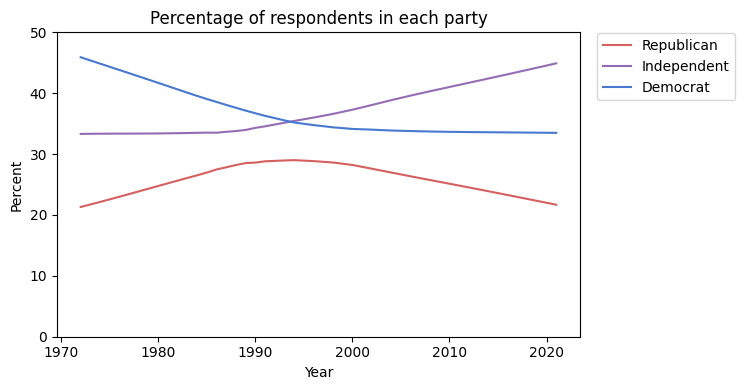

<IPython.core.display.Javascript object>

In [61]:
for column in party_names:
    plot_series_lowess(xtab[column], party_map[column])

decorate(
    xlabel="Year",
    ylabel="Percent",
    ylim=[0, 50],
    title="Percentage of respondents in each party",
)

plt.legend(bbox_to_anchor=(1.02, 1.02))
None

In [62]:
table = gss.pivot_table(index="year", columns="party3", values="conservatism")
table

party3,Democrat,Independent,Republican
year,,,
1973,7.798924,7.618969,9.340002
1974,7.160240,6.935646,8.512276
1975,7.768439,7.168976,9.098202
1976,8.115579,7.383359,8.649344
1977,8.278394,7.733558,9.197612
1978,7.961337,7.512958,8.911921
1980,7.844642,7.432769,9.221492
1982,7.438623,7.348872,8.180546
1983,7.680894,7.554882,8.726718


<IPython.core.display.Javascript object>

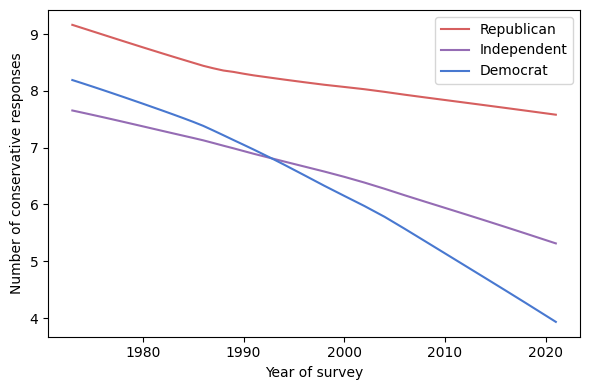

<IPython.core.display.Javascript object>

In [63]:
for column in party_names:
    plot_series_lowess(table[column], color=party_map[column])

decorate(xlabel="Year of survey", ylabel="Number of conservative responses")

In [64]:
for column, series in table.iteritems():
    smooth = make_lowess(series)
    diff = smooth.iloc[-1] - smooth.iloc[1]
    print(column, diff)

Democrat -4.179857819026299
Independent -2.301009907322185
Republican -1.539506883367375


<IPython.core.display.Javascript object>

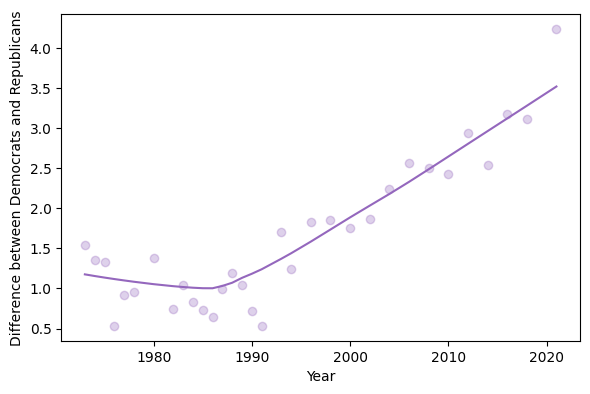

<IPython.core.display.Javascript object>

In [65]:
diff = table["Republican"] - table["Democrat"]
plot_series_lowess(diff, "C4", plot_series=True, label="")
decorate(xlabel="Year", ylabel="Difference between Democrats and Republicans")

In [66]:
series_corr = (
    gss.groupby("year")[["conservatism", "partyid"]]
    .corr()["conservatism"]
    .xs("partyid", level=1)
)

<IPython.core.display.Javascript object>

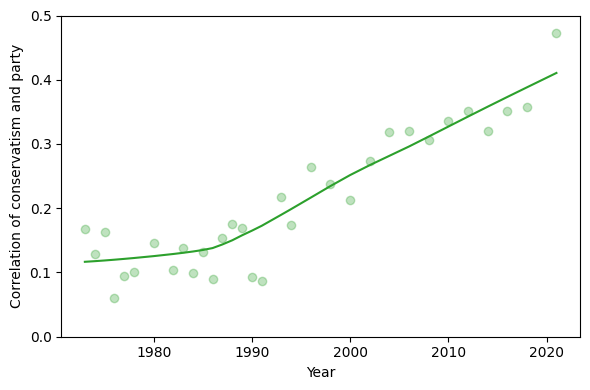

<IPython.core.display.Javascript object>

In [67]:
plot_series_lowess(series_corr, color="C2", plot_series=True, label="")
decorate(xlabel="Year", ylabel="Correlation of conservatism and party", ylim=[0, 0.5])

In [68]:
n = len(gss)
gss["party_jitter"] = gss["partyid"].replace(7, np.nan) + np.random.normal(0, 0.5, n)
gss["con_jitter"] = gss["conservatism"] + np.random.normal(0, 0.2, n)

<IPython.core.display.Javascript object>

In [69]:
yticks = range(7)
ylabels = [
    "Strong democrat",
    "Not very strong democrat",
    "Independent, close to democrat",
    "Independent (neither, no response)",
    "Independent, close to republican",
    "Not very strong republican",
    "Strong Republican",
]

<IPython.core.display.Javascript object>

In [70]:
grouped = gss.groupby("year")

<IPython.core.display.Javascript object>

In [71]:
def make_scatter(year):
    group = grouped.get_group(year)
    plt.plot(group["con_jitter"], group["party_jitter"], "o", alpha=0.05)
    plt.yticks([], [])
    decorate(xlim=[0, 15])

<IPython.core.display.Javascript object>

In [72]:
yticks = [0, 3, 6]
ylabels = [
    "Democrat",
    "Independent",
    "Republican",
]

<IPython.core.display.Javascript object>

In [73]:
def make_scatter(year):
    group = grouped.get_group(year)
    sns.kdeplot(x=group["con_jitter"], y=group["party_jitter"], cut=0)
    series = chunk_series(group, "conservatism", "partyid")
    plot_series_lowess(series, color="C3", label="")
    plt.yticks([], [])
    decorate(
        xlabel="Number of conservative responses",
        ylabel="",
        xlim=[0, 15],
        # ylim=[-1.0, 8],
    )

<IPython.core.display.Javascript object>

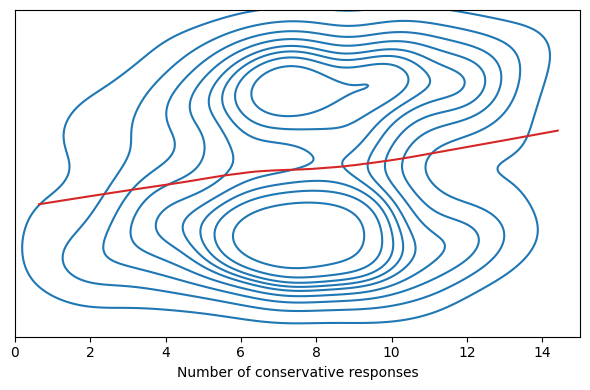

<IPython.core.display.Javascript object>

In [74]:
make_scatter(1988)

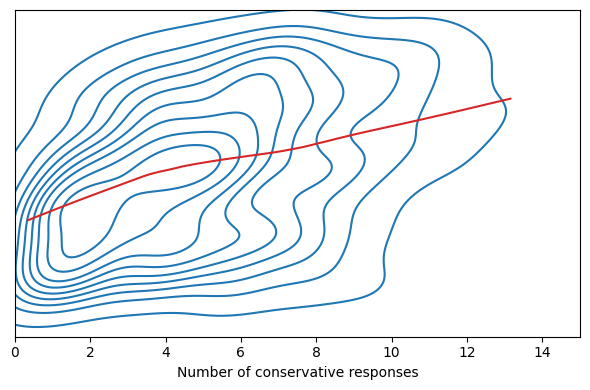

<IPython.core.display.Javascript object>

In [75]:
make_scatter(2018)

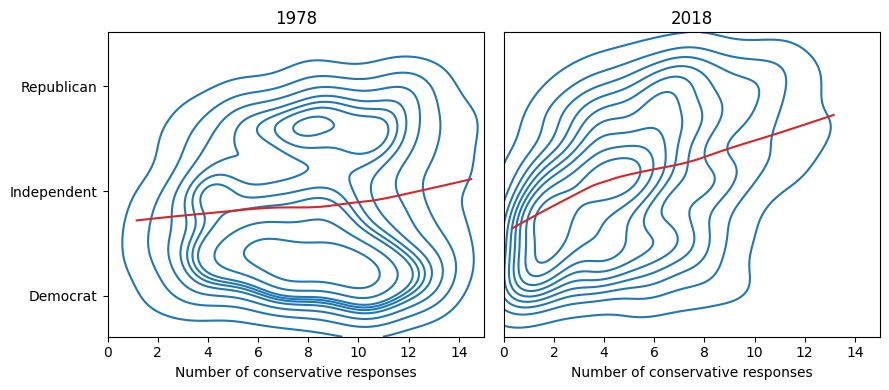

<IPython.core.display.Javascript object>

In [76]:
plt.figure(figsize=(9, 4))

for i, year in enumerate([1978, 2018]):
    plt.subplot(1, 2, i + 1)
    make_scatter(year)
    plt.title(year)
    if i == 0:
        plt.yticks(yticks, ylabels)

In [79]:
gss["party7"] = gss["partyid"].replace(7, np.nan)

<IPython.core.display.Javascript object>

In [178]:
from statsmodels.miscmodels.ordinal_model import OrderedModel


def fit_ordinal(group, y="party7", x="conservatism"):
    data = group.dropna(subset=[x, y])
    if len(data) == 0:
        return None

    mod_log = OrderedModel(data[y], data[[x]], distr="logit")
    res_log = mod_log.fit(method="bfgs", disp=False)
    return res_log

<IPython.core.display.Javascript object>

In [179]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


def predict_ordinal(result, group, x="conservatism"):
    group["party_pred"] = np.nan
    if result is None:
        return

    data = group.dropna(subset=[x])
    if len(data) == 0:
        return

    predicted = result.model.predict(res_log.params, exog=data[[x]])
    p = np.random.random(size=len(data))
    lt = p[:, None] < predicted.cumsum(axis=1)
    rows, cols = np.diff(lt, prepend=False).nonzero()
    data["party_pred"] = cols
    group["party_pred"].fillna(data["party_pred"], inplace=True)

<IPython.core.display.Javascript object>

In [180]:
subset = gss.query("year == 2018")

<IPython.core.display.Javascript object>

In [181]:
res_log = fit_ordinal(subset)

<IPython.core.display.Javascript object>

In [182]:
subset["party_pred"] = np.nan
predict_ordinal(res_log, subset)

subset["party_pred"].value_counts()

3.0    450
1.0    383
0.0    316
5.0    311
4.0    306
2.0    295
6.0    277
Name: party_pred, dtype: int64

<IPython.core.display.Javascript object>

In [183]:
subset["party7"].value_counts()

3.0    408
1.0    367
0.0    318
2.0    313
4.0    290
5.0    276
6.0    249
Name: party7, dtype: int64

<IPython.core.display.Javascript object>

In [191]:
means = subset.groupby("party3")["conservatism"].mean()
means["Republican"] - means["Democrat"]

3.1171189394892655

<IPython.core.display.Javascript object>

In [192]:
subset["party_pred3"] = subset["party_pred"].replace(recode_party)
means = subset.groupby("party_pred3")["conservatism"].mean()
means["Republican"] - means["Democrat"]

3.267450846290531

<IPython.core.display.Javascript object>

In [194]:
gss["party_pred"] = np.nan

for name, group in gss.groupby("year"):
    print(name)
    result = fit_ordinal(group)
    predict_ordinal(result, group)
    gss["party_pred"].fillna(group["party_pred"], inplace=True)

1972
1973
1974
1975
1976
1977
1978
1980
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1993
1994
1996
1998
2000
2002
2004
2006
2008
2010
2012
2014
2016
2018
2021


<IPython.core.display.Javascript object>

In [195]:
gss["party_pred"].value_counts()

3.0    11524
6.0     9981
5.0     9792
4.0     9135
1.0     7942
2.0     7726
0.0     6313
Name: party_pred, dtype: int64

<IPython.core.display.Javascript object>

In [196]:
gss["party_pred3"] = gss["party_pred"].replace(recode_party)
gss["party_pred3"].value_counts()

Independent    28385
Republican     19773
Democrat       14255
Name: party_pred3, dtype: int64

<IPython.core.display.Javascript object>

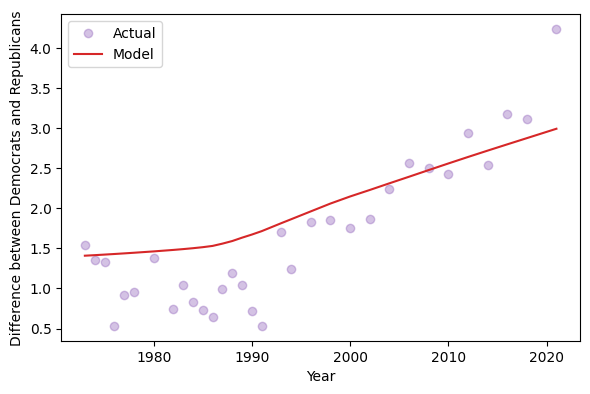

<IPython.core.display.Javascript object>

In [198]:
table = gss.pivot_table(index="year", columns="party3", values="conservatism")
diff = table["Republican"] - table["Democrat"]
diff.plot(style="o", color="C4", alpha=0.4, label="Actual")

table2 = gss.pivot_table(index="year", columns="party_pred3", values="conservatism")
diff2 = table2["Republican"] - table["Democrat"]
plot_series_lowess(diff2, color="C3", label="Model")

decorate(xlabel="Year", ylabel="Difference between Democrats and Republicans")

## Appendix: The Fifteen Questions

This appendix provides the wording of the fifteen questions from the General Social Survey that most distinguish liberals and conservatives, identified by topic and the GSS code name.

Homosexuality (homosex): What about sexual relations between two adults of the same sex--do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all?

Capital punishment (cappun): Do you favor or oppose the death penalty for persons convicted of murder?

Legal cannabis (grass): Do you think the use of marijuana should be made legal or not?

Abortion (abany): Please tell me whether or not you think it should be possible for a pregnant woman to obtain a legal abortion if the woman wants it for any reason?

Prayer in public schools (prayer): The United States Supreme Court has ruled that no state or local government may require the reading of the Lord's Prayer or Bible verses in public schools. What are your views on this--do you approve or disapprove of the court ruling?

Premarital sex (premarsx): There's been a lot of discussion about the way morals and attitudes about sex are changing in this country. If a man and woman have sex relations before marriage, do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all?

Divorce (divlaw): Should divorce in this country be easier or more difficult to obtain than it is now?

Spending on welfare (natfare) and the environment (natenvir): We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount.

* Welfare

* Improving and protecting the environment

Pornography (pornlaw): Which of these statements comes closest to your feelings about pornography laws? 

* There should be laws against the distribution of pornography whatever the age.

* There should be laws against the distribution of pornography to persons under 18.

* There should be no laws forbidding the distribution of pornography.

Open housing law (racopen): Suppose there is a community-wide vote on the general housing issue. There are two possible laws to vote on:

* One law says that a homeowner can decide for himself whom to sell his house to, even if he prefers not to sell to [people of a particular race].

* The second law says that a homeowner cannot refuse to sell to someone because of their race or color.

Which law would you vote for? 

Assisted suicide (letdie1): When a person has a disease that cannot be cured, do you think Doctors should be allowed by law to end the patient's life by some painless means if the patient and his family request it?

Women in politics (fepol): Tell me if you agree or disagree with this statement:  Most men are better suited emotionally for politics than are most women.

Gun control (gunlaw): Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

Sex education (sexeduc): Would you be for or against sex education in the public schools?